# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [1]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-36belgza
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-36belgza
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done


# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone https://github.com/enthought/uchicago-pyanno

Cloning into 'uchicago-pyanno'...
remote: Enumerating objects: 3850, done.
remote: Total 3850 (delta 0), reused 0 (delta 0), pack-reused 3850
Receiving objects: 100% (3850/3850), 2.36 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (2798/2798), done.


In [4]:
%cd uchicago-pyanno

/content/uchicago-pyanno


In [ ]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("/content/uchicago-pyanno/data/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [ ]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [ ]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [ ]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


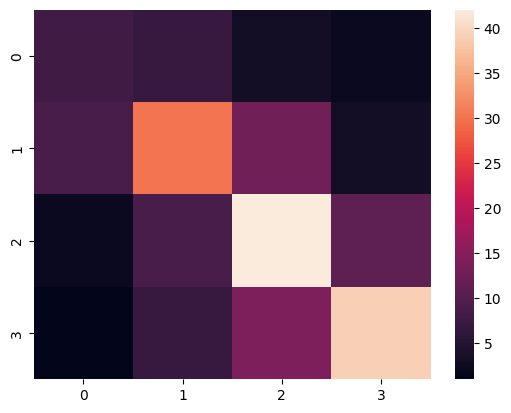

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations[::])

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

- Here I'm loading a coding for an open-ended question on a psychology survey I did previously. We have 4 coders in the end, each address whether paricipants desciption of rest opinion (what is rest?) encapsulated certain behaviors (e.g. using social media, go out and walk, etc. we have a detailed coding scheme)



In [ ]:
import pandas as pd
import numpy as np
# load df from "expanded_df.csv"
coding_df = pd.read_csv("expanded_df.csv")

In [ ]:
coding_df

,Unnamed: 0,Coder 1 - P1,Coder 1 - P2,Coder 1 - P3,Coder 1 - P4,Coder 1 - P5,Coder 1 - P6,Coder 1 - P7,Coder 1 - P8,Coder 1 - P9,...,Coder 4 - P11,Coder 4 - P12,Coder 4 - P13,Coder 4 - P14,Coder 4 - P15,Coder 4 - P16,Coder 4 - P17,Coder 4 - P18,Coder 4 - P19,Coder 4 - P20
0,TV,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,Youtube/other,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,1
2,Music,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
3,Social Media,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,Walk,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
5,Exercise,1,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
6,Social,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,Mindful practice,1,0,1,0,0,0,1,0,0,...,1,1,0,0,0,1,1,1,1,1


In [ ]:
# change first column to be the index
coding_df = coding_df.set_index(coding_df.columns[0])

In [ ]:
coding_df.head()

,Coder 1 - P1,Coder 1 - P2,Coder 1 - P3,Coder 1 - P4,Coder 1 - P5,Coder 1 - P6,Coder 1 - P7,Coder 1 - P8,Coder 1 - P9,Coder 1 - P10,...,Coder 4 - P11,Coder 4 - P12,Coder 4 - P13,Coder 4 - P14,Coder 4 - P15,Coder 4 - P16,Coder 4 - P17,Coder 4 - P18,Coder 4 - P19,Coder 4 - P20
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TV,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Youtube/other,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,1
Music,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
Social Media,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
Walk,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1


In [ ]:
import numpy as np
from pyanno.annotations import AnnotationsContainer

# Assuming 'coding_df' is your expanded DataFrame

# Initialize an empty list to hold the reshaped data
reshaped_data = []

# Loop over each activity
for activity in coding_df.index:
    # For each participant, aggregate the coders' judgments
    for participant in range(1, 21):
        participant_data = []
        for coder in range(1, 5):
            # Construct the column name for the current coder and participant
            column_name = f'Coder {coder} - P{participant}'
            # Append the coder's judgment for the current activity and participant
            participant_data.append(coding_df.loc[activity, column_name])
        # Append the aggregated judgments for the current participant and activity
        reshaped_data.append(participant_data)

# Convert the list to a NumPy array
annotations_array = np.array(reshaped_data)

# Create an AnnotationsContainer with the reshaped data
anno_psych = AnnotationsContainer.from_array(annotations_array)

# Now, you can proceed with your analysis using PyAnno's models and tools
# For example, initializing a model and training it with the annotations
# model = models.AnnotationModel(...)
# model.mle(annotations_container)


In [ ]:
anno_psych.annotations[:5]

array([[1, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0]])

In [ ]:
anno_psych.labels # everything is binary

[0, 1]

In [ ]:
pyanno.measures.agreement.labels_frequency(anno_psych.annotations, 2) # 2 for binary coding
# the result is the frequency of 0 and 1 respectively, not meaningful in our case

array([0.425, 0.575])

[[65.  7.]
 [33. 55.]]


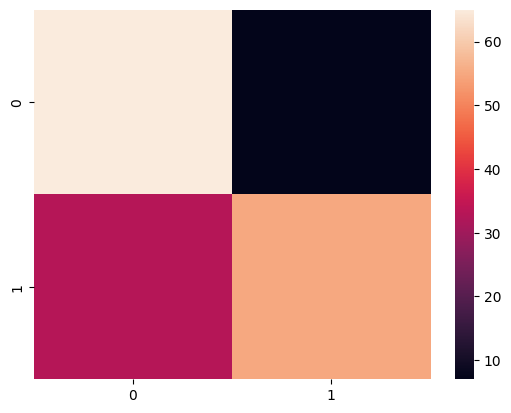

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno_psych.annotations[:,0], anno_psych.annotations[:,1],2)
print(c)
ac = seaborn.heatmap(c)
plt.show()



- Consider our binary coding: [0, 1], the four blocks above represent (from top-left to bottom right): True Negative (00), False Positive(01), False Negative (10), True Positive (11).
- i.e. considering the first 2 coders, 65 time both coder give 0, 55 time both 1; while there are some deviations where 7 times the first coder gave 0 but second gave 1, 33 time reversely

- I know that it was due to the high disagreement amount the definition of `exercise` and `mindfulness` in the first version of our rubric.


In [ ]:
pairwise_metric_average(cohens_kappa,anno_psych.annotations) ## looks like the agreement is quiet low

0.3675578076827011

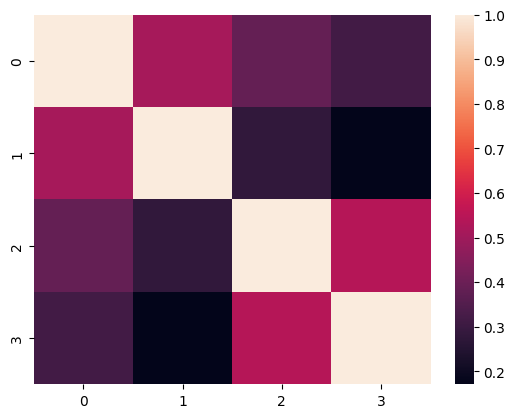

In [ ]:
cohens_kappa(anno_psych.annotations[:,0], anno_psych.annotations[:,1])
m = pairwise_matrix(cohens_kappa, anno_psych.annotations)
an = seaborn.heatmap(m)
plt.show()

- We can see that e.g. coder number 1 and 3 have to most disagreement.

-- Seems like I'm not storing and importing the data correctly... there shouldn't be that much disagreement and low cohen score. (to be check later)

- Also, I'm not testing with pearson and spearmans rho since it is not a correlational situation: our codings are binary entirely

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [ ]:
dfTrain['vect']

And let's see what np.stack(dfTrain['vect']) does:

In [ ]:
np.stack(dfTrain['vect'])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

This lets us look at which classes do better:

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [ ]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory=''), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

In [ ]:
dfTrain

In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [ ]:
import numpy as np
import pandas as pd
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.neighbors
import sklearn.svm
import sklearn.neural_network

In [ ]:
# create 10 distinct artificial dataset using above function

noise = 0.2


df_train_1, df_test_1 = sklearn.model_selection.train_test_split(lucem_illud.random(), test_size=.2)
df_train_2, df_test_2 = sklearn.model_selection.train_test_split(lucem_illud.random(), test_size=.2)
df_train_3, df_test_3 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
df_train_4, df_test_4 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
df_train_5, df_test_5 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
df_train_6, df_test_6 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
df_train_7, df_test_7 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
df_train_8, df_test_8 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
df_train_9, df_test_9 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)
df_train_10, df_test_10 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)


In [ ]:
df_train_1.head()

,vect,category
833,"[-0.34199521998080074, -0.007706390467492996]",1
410,"[0.8282262697787202, 0.1408434274414978]",0
521,"[0.2642840138095277, 0.5181681082040426]",1
7,"[0.10366504602008009, -0.6048598021448488]",1
757,"[0.43483986689682097, -0.5520364509949227]",1


In [ ]:
df_train_6.head()

,vect,category
351,"[-0.9962343075282181, -0.8895316517044647]",1
467,"[-0.284418913263083, -0.3365621076979441]",1
25,"[-0.6517246179872063, -0.674938637551924]",1
405,"[-0.5479694632609264, -0.3784420685411525]",1
162,"[0.8088225651711761, -0.9654279235446062]",0


- Let's try different models on the datasets above

I simply curated models with the help of GPT agent:

In [ ]:
### many models~

from sklearn.naive_bayes import GaussianNB
# Bayesian
clf_gaussianNB = sklearn.naive_bayes.GaussianNB()
clf_multinomialNB = sklearn.naive_bayes.MultinomialNB()
clf_bernoulliNB = sklearn.naive_bayes.BernoulliNB()

# Linear Models
clf_logisticRegression = sklearn.linear_model.LogisticRegression()
clf_sgdClassifier = sklearn.linear_model.SGDClassifier()

# Trees
clf_decisionTree = sklearn.tree.DecisionTreeClassifier()
clf_extraTreeClassifier = sklearn.tree.ExtraTreeClassifier()

# Ensemble Methods
clf_randomForest = sklearn.ensemble.RandomForestClassifier()
clf_gradientBoosting = sklearn.ensemble.GradientBoostingClassifier()
clf_adaboost = sklearn.ensemble.AdaBoostClassifier()
clf_bagging = sklearn.ensemble.BaggingClassifier()
clf_extraTrees = sklearn.ensemble.ExtraTreesClassifier()

# Neighbors
clf_kNeighbors = sklearn.neighbors.KNeighborsClassifier()
clf_radiusNeighbors = sklearn.neighbors.RadiusNeighborsClassifier()

# SVM
clf_svc = sklearn.svm.SVC()
clf_linearSVC = sklearn.svm.LinearSVC()

# Neural Network Models
clf_mlpClassifier = sklearn.neural_network.MLPClassifier()

# Others
clf_passiveAggressiveClassifier = sklearn.linear_model.PassiveAggressiveClassifier()
clf_ridgeClassifier = sklearn.linear_model.RidgeClassifier()


In [ ]:
# These are everything I tried, including extra models
classifiers = {
    'GaussianNB': sklearn.naive_bayes.GaussianNB(),
    'LogisticRegression': sklearn.linear_model.LogisticRegression(),
    'SGDClassifier': sklearn.linear_model.SGDClassifier(),
    'DecisionTree': sklearn.tree.DecisionTreeClassifier(),
    'ExtraTreeClassifier': sklearn.tree.ExtraTreeClassifier(),
    'RandomForest': sklearn.ensemble.RandomForestClassifier(),
    'GradientBoosting': sklearn.ensemble.GradientBoostingClassifier(),
    'AdaBoost': sklearn.ensemble.AdaBoostClassifier(),
    'Bagging': sklearn.ensemble.BaggingClassifier(),
    'ExtraTrees': sklearn.ensemble.ExtraTreesClassifier(),
    'KNeighbors': sklearn.neighbors.KNeighborsClassifier(),
    'RadiusNeighbors': sklearn.neighbors.RadiusNeighborsClassifier(),
    'SVC': sklearn.svm.SVC(),
    'LinearSVC': sklearn.svm.LinearSVC(),
    'MLPClassifier': sklearn.neural_network.MLPClassifier(),
    'PassiveAggressiveClassifier': sklearn.linear_model.PassiveAggressiveClassifier(),
    'RidgeClassifier': sklearn.linear_model.RidgeClassifier(),
}

In [ ]:
def evaluate_classifiers(classifiers, datasets): # this didn't work well, I use next function
    results = []

    for clf_name, clf in classifiers.items():
        for i in range(1, 11):  # Assuming dataset indices range from 1 to 10
            # Load training and test datasets
            df_train = datasets[f'df_train_{i}']
            df_test = datasets[f'df_test_{i}']

            # Fit the classifier
            clf.fit(np.stack(df_train['vect'], axis=0), df_train['category'])

            # Evaluate the classifier
            result = lucem_illud.evaluateClassifier(clf, df_test)

            # Store results with additional info
            result['Classifier'] = clf_name
            result['Dataset'] = f'Dataset {i}'
            results.append(result)

    # Combine all results into a single DataFrame
    final_results = pd.concat(results, ignore_index=True)
    return final_results

In [ ]:
def evaluate_classifiers_on_dataset(classifiers, df_train, df_test):
  # I use this function for testing
  # also, I excluded the plotings for managable upload
    results = {}

    for clf_name, clf in classifiers.items():
        # Fit the classifier
        clf.fit(np.stack(df_train['vect'], axis=0), df_train['category'])

        # Evaluate the classifier
        result = lucem_illud.evaluateClassifier(clf, df_test)

        # Store results with classifier name
        results[clf_name] = result

    return results


In [ ]:
# try those functions and ploting first

clf_gaussianNB.fit(np.stack(df_train_1['vect'], axis=0), df_train_1['category'])
lucem_illud.evaluateClassifier(clf_gaussianNB, df_test_1) # this returns a pandas dataframe


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.525,0.481454,0.460317,0.466036,0.610526
1,0.525,0.481454,0.500000,0.516190,0.352381


In [ ]:
clf_randomForest.fit(np.stack(df_train_9['vect'], axis=0), df_train_9['category'])
lucem_illud.evaluateClassifier(clf_randomForest, df_test_9) # this returns a pandas dataframe


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.044,0.948460,0.870690,0.828256,0.935185
1,0.044,0.916439,0.910112,0.803991,0.852632
2,0.032,0.938750,0.946809,0.864660,0.890000
3,0.046,0.940476,0.876106,0.821097,0.916667
4,0.014,0.973878,0.965909,0.930497,0.955056


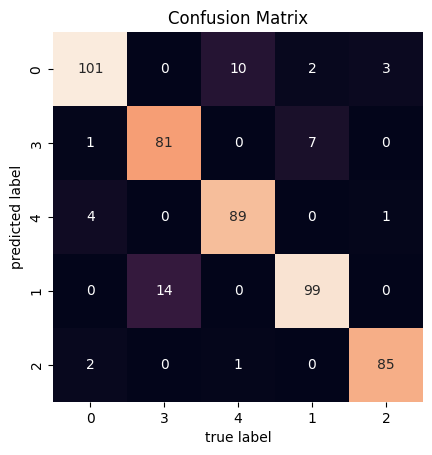

In [ ]:
lucem_illud.plotConfusionMatrix(clf_randomForest, df_test_9)

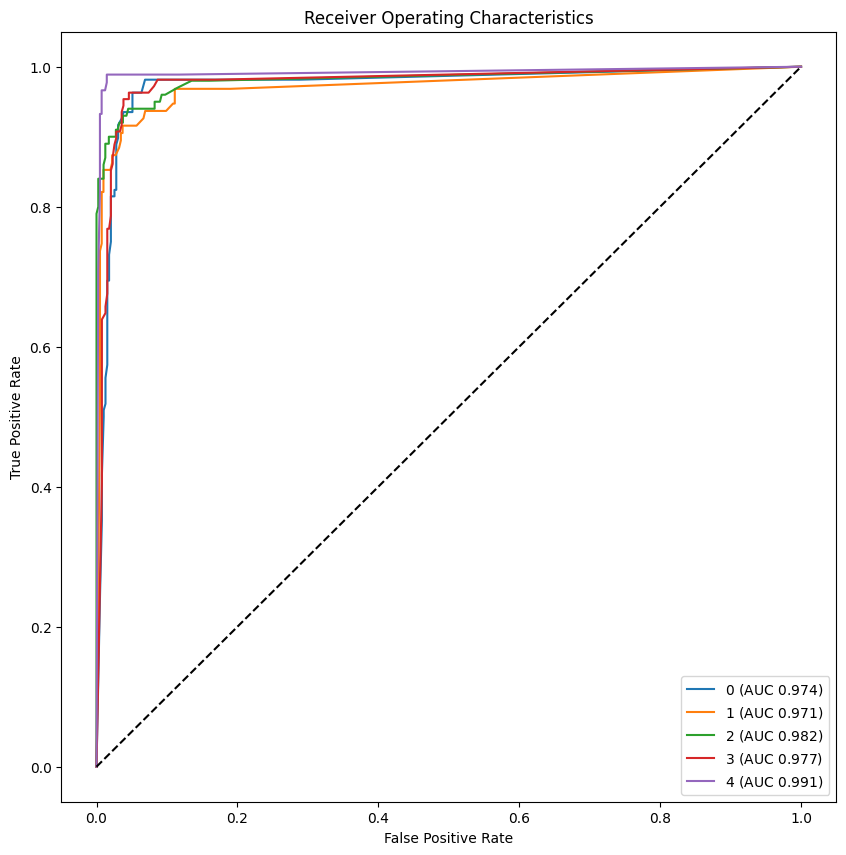

In [ ]:
lucem_illud.plotMultiROC(clf_randomForest, df_test_9)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


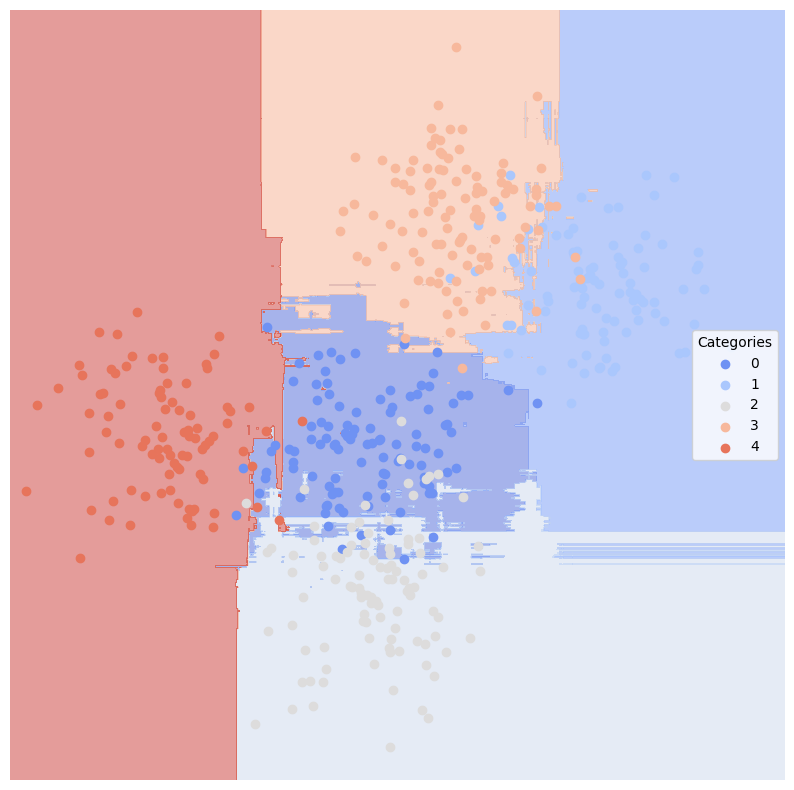

In [ ]:
lucem_illud.plotregions(clf_randomForest, df_test_9)

In [ ]:
datasets = {
    'df_train_1': df_train_1, 'df_test_1': df_test_1,
    'df_train_2': df_train_2, 'df_test_2': df_test_2,
    'df_train_3': df_train_3, 'df_test_3': df_test_3,
    'df_train_4': df_train_4, 'df_test_4': df_test_4,
    'df_train_5': df_train_5, 'df_test_5': df_test_5,
    'df_train_6': df_train_6, 'df_test_6': df_test_6,
    'df_train_7': df_train_7, 'df_test_7': df_test_7,
    'df_train_8': df_train_8, 'df_test_8': df_test_8,
    'df_train_9': df_train_9, 'df_test_9': df_test_9,
    'df_train_10': df_train_10, 'df_test_10': df_test_10
}

#### Model fit and evaluation on toy dataset start here

In [ ]:
results_df1 = evaluate_classifiers_on_dataset(classifiers, df_train_1, df_test_1)

In [ ]:
results_df1

{'GaussianNB':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.525  0.481454   0.460317           0.466036  0.610526
 1              0.525  0.481454   0.500000           0.516190  0.352381,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0                0.5  0.503258   0.477876           0.476635  0.568421
 1                0.5  0.503258   0.528736           0.526637  0.438095,
 'SGDClassifier':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0                0.5  0.510276   0.482270           0.480203  0.715789
 1                0.5  0.510276   0.542373           0.530295  0.304762,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision   

In [ ]:
result_df2 = evaluate_classifiers_on_dataset(classifiers, df_train_2, df_test_2)
result_df2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'GaussianNB':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.495  0.505502   0.495238           0.492779  0.530612
 1              0.495  0.505502   0.515789           0.512781  0.480392,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.485  0.516307   0.504425           0.498390  0.581633
 1              0.485  0.516307   0.528736           0.518449  0.450980,
 'SGDClassifier':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0                0.5  0.494798   0.479167           0.487457  0.234694
 1                0.5  0.494798   0.506579           0.507417  0.754902,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision   

We can see that no particular model can really have prediction power when it comes to the **random dataset**.

For both dataset generated by random pattern: (1 and 2)

- All `AUC`, and `error rates` are around 0.5, suggesting it is just like *guessing* between 0 or 1 -- indeed, the values are random


In [ ]:
result_df3 = evaluate_classifiers_on_dataset(classifiers, df_train_3, df_test_3)
result_df3

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'GaussianNB':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.045  0.955138   0.961905           0.941532  0.952830
 1              0.045  0.955138   0.947368           0.927055  0.957447,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.045  0.955138   0.961905           0.941532  0.952830
 1              0.045  0.955138   0.947368           0.927055  0.957447,
 'SGDClassifier':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.075  0.928643   0.989247           0.928592  0.867925
 1              0.075  0.928643   0.869159           0.864913  0.989362,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision   

In [ ]:
result_df4 = evaluate_classifiers_on_dataset(classifiers, df_train_4, df_test_4)
result_df4

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'GaussianNB':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0               0.04  0.959784   0.968750           0.944324  0.948980
 1               0.04  0.959784   0.951923           0.938925  0.970588,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0               0.04  0.959784   0.968750           0.944324  0.948980
 1               0.04  0.959784   0.951923           0.938925  0.970588,
 'SGDClassifier':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0               0.04  0.959584   0.978723           0.948802  0.938776
 1               0.04  0.959584   0.943396           0.934898  0.980392,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision   

Above are for **andSplit** pattern (3 and 4)

- We can see clearly that ALL model performed extremely well for andSplit datasets, hitting 95% accuracy when predicting

In [ ]:
result_df5 = evaluate_classifiers_on_dataset(classifiers, df_train_5, df_test_5)
result_df5

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'GaussianNB':           Error_Rate      AUC  Precision  Average_Precision    Recall
 Category                                                             
 0              0.475  0.53208   0.500000           0.491842  0.673684
 1              0.475  0.53208   0.569444           0.542354  0.390476,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.555  0.453885   0.441176           0.453638  0.631579
 1              0.555  0.453885   0.453125           0.505149  0.276190,
 'SGDClassifier':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.545  0.450877   0.416667           0.453509  0.368421
 1              0.545  0.450877   0.482759           0.502471  0.533333,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision    Rec

In [ ]:
result_df6 = evaluate_classifiers_on_dataset(classifiers, df_train_6, df_test_6)
result_df6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'GaussianNB':           Error_Rate      AUC  Precision  Average_Precision    Recall
 Category                                                             
 0                0.5  0.50095   0.506173           0.505476  0.405941
 1                0.5  0.50095   0.495798           0.495476  0.595960,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0               0.48  0.520552   0.528090           0.515745  0.465347
 1               0.48  0.520552   0.513514           0.505659  0.575758,
 'SGDClassifier':           Error_Rate  AUC  Precision  Average_Precision  Recall
 Category                                                       
 0              0.505  0.5      0.000              0.505     0.0
 1              0.505  0.5      0.495              0.495     1.0,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category               

Above are for **xorSplit** pattern (5 and 6)

- for xorSplit pattern: GaussianNB,LogisticRegression,SGDClassifier,AdaBoost,LinearSVC,PassiveAggressiveClassifier, and RidgeClassifier failed to yield good score in both dfs
- all other model achieved somewhere between 75% - 90% accuracy of prediction

In [ ]:
result_df7 = evaluate_classifiers_on_dataset(classifiers, df_train_7, df_test_7)
result_df7

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'GaussianNB':           Error_Rate      AUC  Precision  Average_Precision    Recall
 Category                                                             
 0                0.1  0.89599   0.871795           0.856057  0.953271
 1                0.1  0.89599   0.939759           0.863185  0.838710,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.635  0.381218   0.307692           0.501010  0.149533
 1              0.635  0.381218   0.385135           0.416051  0.612903,
 'SGDClassifier':           Error_Rate  AUC  Precision  Average_Precision  Recall
 Category                                                       
 0              0.465  0.5      0.535              0.535     1.0
 1              0.465  0.5      0.000              0.465     0.0,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category               

In [ ]:
result_df8 = evaluate_classifiers_on_dataset(classifiers, df_train_8, df_test_8)
result_df8

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'GaussianNB':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0                0.1  0.893939     0.8750           0.860227  0.954545
 1                0.1  0.893939     0.9375           0.856250  0.833333,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0               0.51  0.493939   0.543478           0.547036  0.454545
 1               0.51  0.493939   0.444444           0.447037  0.533333,
 'SGDClassifier':           Error_Rate  AUC  Precision  Average_Precision  Recall
 Category                                                       
 0               0.45  0.5       0.55               0.55     1.0
 1               0.45  0.5       0.00               0.45     0.0,
 'DecisionTree':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category           

Above are for **targetSplit** pattern (7 and 8)

- For this data situation, SGDClassifier, LogisticRegression, LinearSVC, PassiveAggressiveClassifier, and RidgeClassifier, failed horribly for both dfs;
- All other model perform equally well around 90%

In [ ]:
result_df9 = evaluate_classifiers_on_dataset(classifiers, df_train_9, df_test_9)
result_df9

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dis

{'GaussianNB':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.060  0.914777   0.854545           0.771771  0.870370
 1              0.036  0.937492   0.913978           0.837770  0.894737
 2              0.038  0.927500   0.935484           0.839871  0.870000
 3              0.036  0.950208   0.909091           0.857751  0.925926
 4              0.018  0.980248   0.925532           0.908733  0.977528,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.062  0.913502   0.846847           0.765070  0.870370
 1              0.036  0.937492   0.913978           0.837770  0.894737
 2              0.038  0.923750   0.945055           0.840747  0.860000
 3              0.036  0.950208   0.909091           0.857751  0.925926
 4              0.020  0.97

In [ ]:
result_df10 = evaluate_classifiers_on_dataset(classifiers, df_train_10, df_test_10)
result_df10

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dis

{'GaussianNB':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0              0.000  1.000000   1.000000           1.000000  1.000000
 1              0.094  0.845991   0.728261           0.592241  0.752809
 2              0.094  0.846306   0.770833           0.626178  0.747475
 3              0.000  1.000000   1.000000           1.000000  1.000000
 4              0.000  1.000000   1.000000           1.000000  1.000000,
 'LogisticRegression':           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 0               0.00  1.000000    1.00000           1.000000  1.000000
 1               0.09  0.852825    0.73913           0.606729  0.764045
 2               0.09  0.852603    0.78125           0.639856  0.757576
 3               0.00  1.000000    1.00000           1.000000  1.000000
 4               0.00  1.00

Above are for **multiBlobs** pattern (9 and 10)

- Looks like most classifiers are performing very well in both df;
-  (there seems to be some issue with category 1 and 2 in the second df df_10)PassiveAggressiveClassifier and Ridgeclassifier failed to categorize any category 2.
- Ridgeclassifier also failed at categorizing one category in df_9

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [6]:
ObamaClintonReleases = pandas.read_csv('/content/uchicago-pyanno/data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [7]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [8]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [10]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [11]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [56]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [13]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [57]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [58]:
TFVects.shape

(1367, 11267)

We can save this in the dataframe to make things easier

In [59]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [61]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [62]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

<ipython-input-162-c9d2b7441e78>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-162-c9d2b7441e78>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


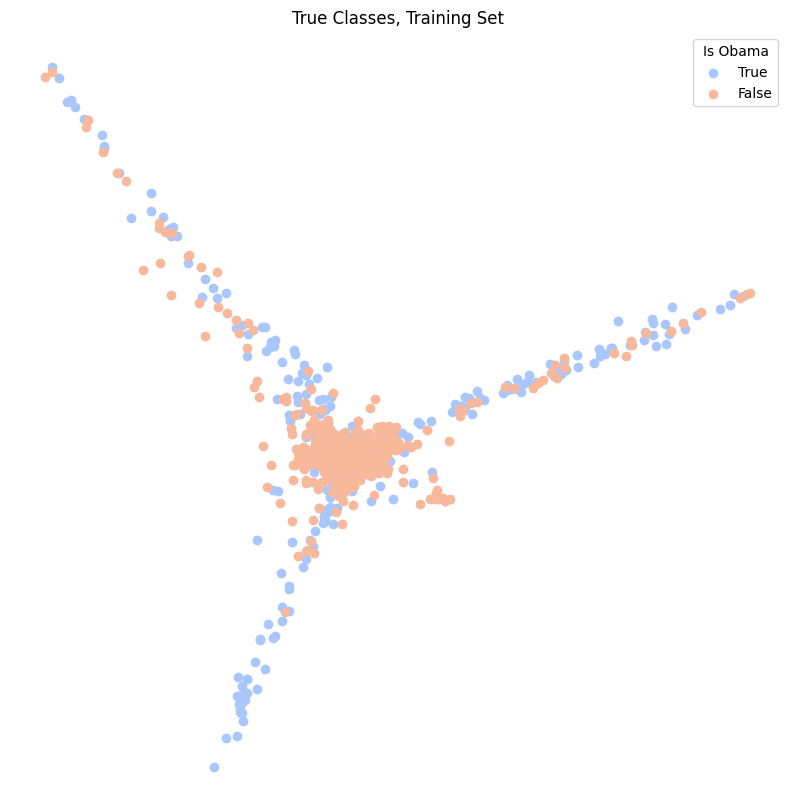

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

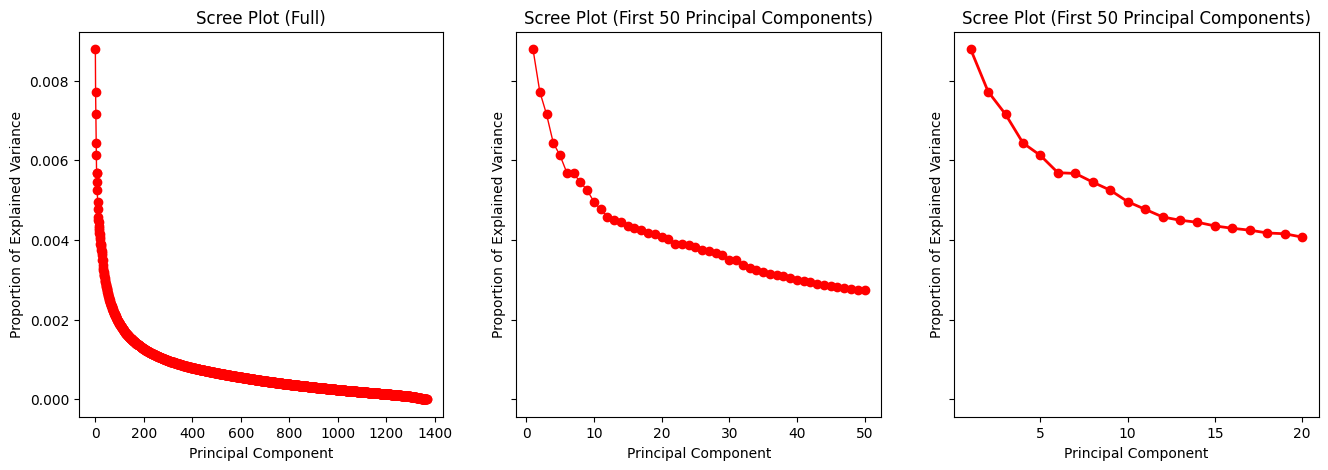

In [63]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6708119970738844

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6432748538011696

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7512801755669349
Testing:
0.7192982456140351


Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8412582297000731
Testing:
0.7660818713450293


Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8792977322604243
Testing:
0.8011695906432749


This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9202633504023409
Testing:
0.8187134502923976


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.964155084125823


Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.827485380116959


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [3]:
arknights_plot_path = "/content/uchicago-pyanno/data/all_plots.csv"


- I've already done preprocessing (tokenize and normalized) before

In [4]:
import pandas as pd
arknights_plot_df = pd.read_csv(arknights_plot_path, index_col=0)
arknights_plot_df.head()


,Character,Dialogue,tokenized_sents,normalized_sents
Story,,,,
main_0_Evil Time Part 1.xlsx,non-character,It's been a long time since we've last seen...,"[['It', ""'s"", 'been', 'a', 'long', 'time', 'si...","[['long', 'time', 've', 'seen']]"
main_0_Evil Time Part 1.xlsx,non-character,During this time... you've been teetering o...,"[['During', 'this', 'time'], ['you', ""'ve"", 'b...","[['time'], ['ve', 'teetering', 'edge', 'cliff']]"
main_0_Evil Time Part 1.xlsx,non-character,"You may have forgotten who you are, but jus...","[['You', 'may', 'have', 'forgotten', 'who', 'y...","[['forgotten', 'remembering']]"
main_0_Evil Time Part 1.xlsx,non-character,...It's time. Don't linger here for too long.,"[['It', ""'s"", 'time'], ['Do', ""n't"", 'linger',...","[['time'], ['linger', 'long']]"
main_0_Evil Time Part 1.xlsx,non-character,"After all, you aren't my guest yet, nor sho...","[['After', 'all', 'you', 'are', ""n't"", 'my', '...",[['guest']]


In [39]:
# prompt: Imitate  several cells above, create a TFVects on the "Dialogue" column. Before doing the vectorization, make sure to only include the date where "Character" are either 'Amiya' or "Kal'tsit"

arknights_plot_df_filtered = arknights_plot_df[arknights_plot_df['Character'].isin(['Amiya', "Kal'tsit"])]

In [40]:
# see unique characters
arknights_plot_df_filtered.Character.unique()

array(['Amiya', "Kal'tsit"], dtype=object)

In [41]:
arknights_plot_df_filtered['category'] = [c == 'Amiya' for c in arknights_plot_df_filtered['Character']]

<ipython-input-41-9aeb25ddc4d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['category'] = [c == 'Amiya' for c in arknights_plot_df_filtered['Character']]


In [64]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(arknights_plot_df_filtered, test_size=holdBackFraction)

In [65]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['Dialogue'])

In [70]:
TFVects.shape

(6415, 2947)

In [67]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [68]:
train_data_df.vect

Story
main_2_Separated Hearts.xlsx          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
main_6_Partial Necrosis.xlsx          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
main_2_Separated Hearts.xlsx          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
main_11_Return To Mist.xlsx           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
main_8_Roaring Flare.xlsx             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                            ...                        
main_8_Roaring Flare.xlsx             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
act13side_Near Light.xlsx             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
main_8_Roaring Flare.xlsx             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
act8mini_Vigilo.xlsx                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
act3d0_Heart of Surging Flame.xlsx    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: vect, Length: 6415, 

In [71]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

<ipython-input-72-438860c5cf52>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-72-438860c5cf52>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


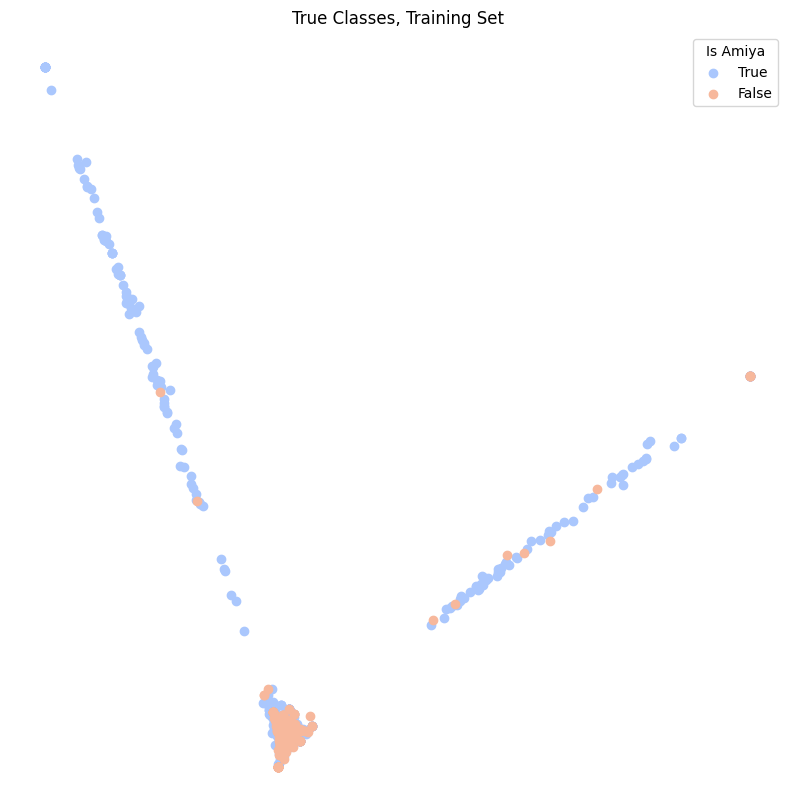

In [72]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Amiya
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Amiya
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Amiya')
plt.title('True Classes, Training Set')
plt.show()

In [51]:
TFVects.shape

(6415, 2954)

- Let's try the logistic regression to distinguish between the characters based on the dialogue


In [74]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [75]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

In [76]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.572564302416212

In [80]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['Dialogue'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.5679551122194514

- Looks like the performance are not so good, but slightly better than guessing

In [81]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.6919719407638347
Testing:
0.6577306733167082


In [82]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.7123928293063133
Testing:
0.6521197007481296


- With higher dimensions, the performance is getting better (interestingly, this is also reaching around 65%-70%)

In [86]:
train_data_df['vect'].shape

(6415,)

In [90]:
logistic_l1= sklearn.linear_model.LogisticRegression()
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8146531566640686


In [91]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.6814214463840399


- Use the lucem_illud to visualize and calculate the performance of the model


In [96]:
lucem_illud.evaluateClassifier(logistic_l1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.318579,0.675748,0.697115,0.601336,0.574637
True,0.318579,0.675748,0.671429,0.639436,0.776860


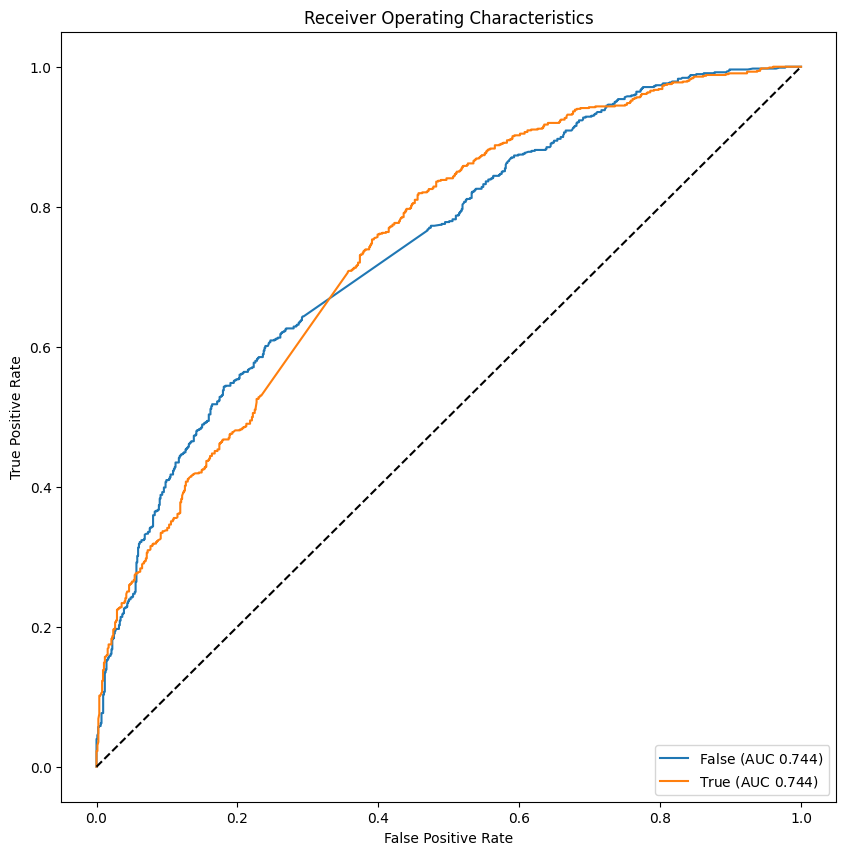

In [95]:
lucem_illud.plotMultiROC(logistic_l1, test_data_df)

- This model has an AUC around .68, a score a little better than guessing. Looks like the logistic regression (using TF-idf vectors) didn't work that well with our data.

- Probably because I deliberately select characters that are not different too much from each other

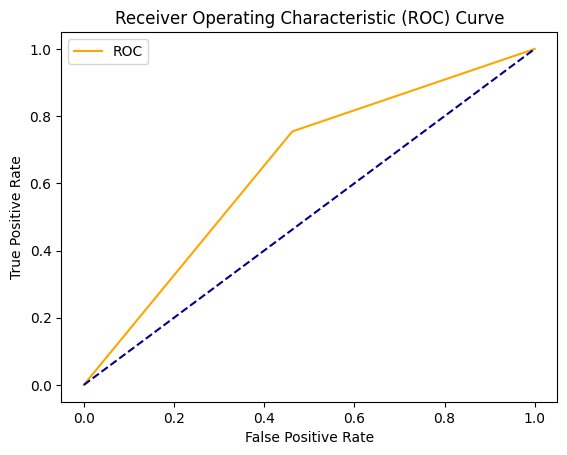

Precision: 0.6461071789686552
Recall: 0.7544273907910272
F-measure: 0.696078431372549
AUC: 0.6460380018684331


In [93]:
# I leave another snippet generated by AI here, looks like there are a little differences in the result, but not too much
# I'm trying to interpret the differences here
# prompt: Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization.

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Calculate precision, recall, F-measure, and AUC
precision = precision_score(test_data_df['category'], logistic.predict(np.stack(test_data_df['pca_reduced_400'], axis=0)))
recall = recall_score(test_data_df['category'], logistic.predict(np.stack(test_data_df['pca_reduced_400'], axis=0)))
f1 = f1_score(test_data_df['category'], logistic.predict(np.stack(test_data_df['pca_reduced_400'], axis=0)))
auc = roc_auc_score(test_data_df['category'], logistic.predict(np.stack(test_data_df['pca_reduced_400'], axis=0)))

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f1)
print("AUC:", auc)


# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


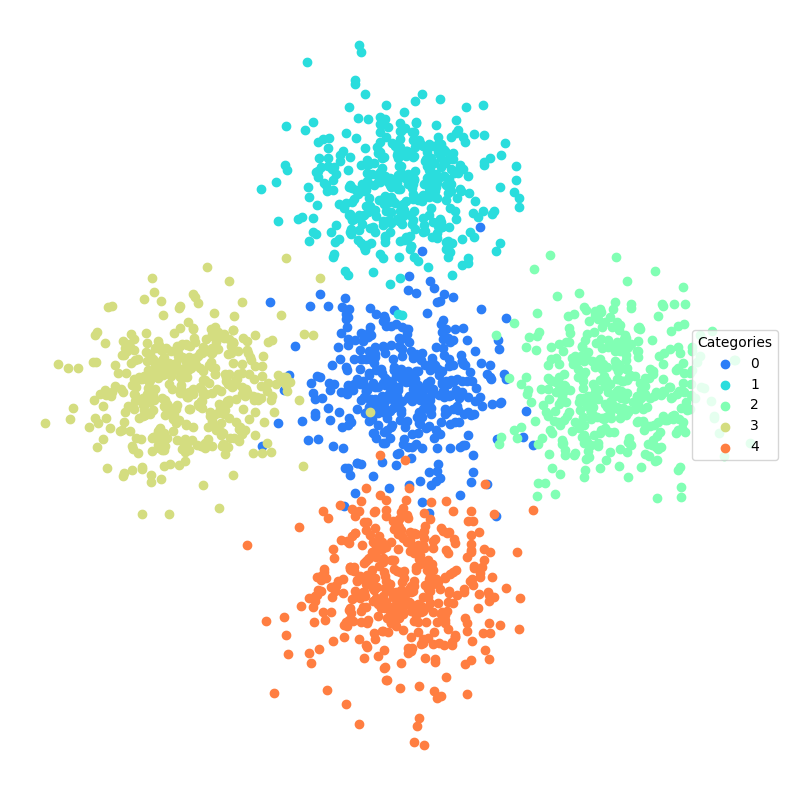

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


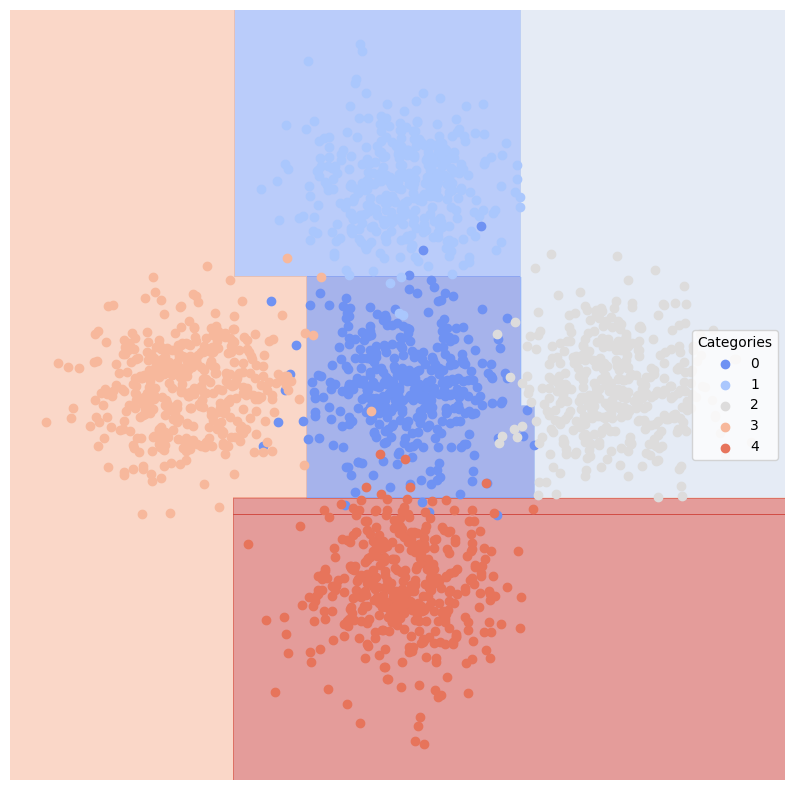

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.030,0.964624,0.913793,0.882631,0.954955
1,0.006,0.985714,1.000000,0.977429,0.971429
2,0.016,0.968355,0.979798,0.934722,0.941748
3,0.012,0.983663,0.955056,0.937101,0.977011
4,0.004,0.993449,0.989362,0.980837,0.989362


Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.966

What happens if we trim the tree?

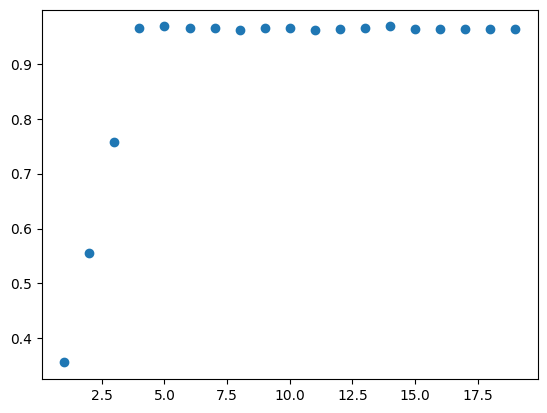

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


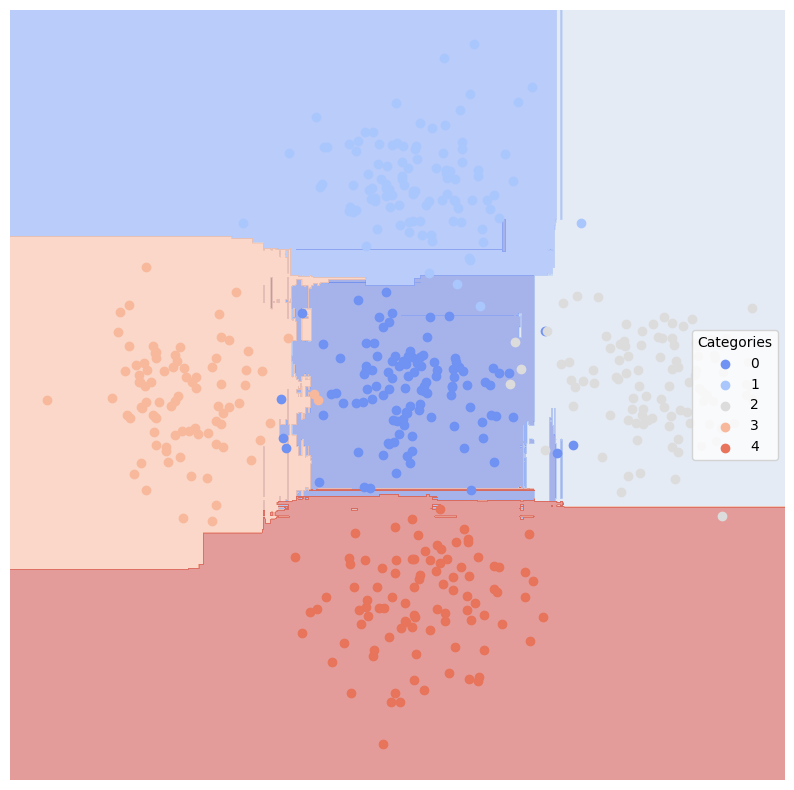

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.030,0.958186,0.928571,0.884013,0.936937
1,0.006,0.985714,1.000000,0.977429,0.971429
2,0.016,0.975545,0.961165,0.931838,0.961165
3,0.010,0.984874,0.965909,0.947704,0.977011
4,0.006,0.992218,0.978947,0.970533,0.989362


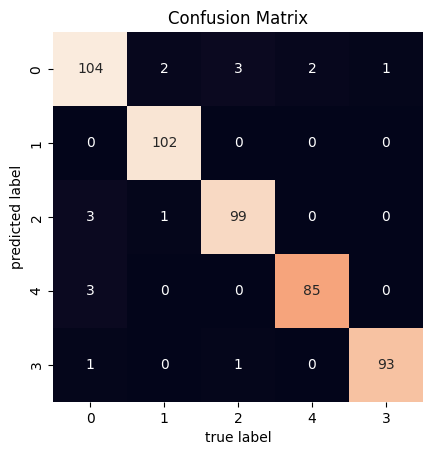

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [5]:
key_characters = ['Amiya', "Kal'tsit", "Ch'en", 'W']

In [6]:
# filter only those characters' dialogues
arknights_plot_df_filtered = arknights_plot_df[arknights_plot_df['Character'].isin(key_characters)]


In [102]:
arknights_plot_df_filtered.Character.unique()

array(['Amiya', "Kal'tsit", 'W', "Ch'en"], dtype=object)

In [7]:
#Create arknights_plot_df_filtered["category"], 0,1,2,3 repectively to the four key characters

arknights_plot_df_filtered["category"] = arknights_plot_df_filtered['Character'].apply(lambda c: key_characters.index(c))


<ipython-input-7-87221ee98bc9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered["category"] = arknights_plot_df_filtered['Character'].apply(lambda c: key_characters.index(c))


In [8]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(arknights_plot_df_filtered['Dialogue'])
TFVects.shape

(11549, 4042)

In [9]:
arknights_plot_df_filtered['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

<ipython-input-9-93bfb398522c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['vect'] = [np.array(v).flatten() for v in TFVects.todense()]


In [132]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(arknights_plot_df_filtered, test_size=holdBackFraction)

In [123]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [133]:
train_data_df

,Character,Dialogue,tokenized_sents,normalized_sents,category,vect
Story,,,,,,
main_7_The Birth of Tragedy.xlsx,Amiya,"You're really going to hire us like this, Mi...","[['You', ""'re"", 'really', 'going', 'to', 'hire...","[['going', 'hire', 'like', 'miss', 'fumizuki']]",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
main_4_Burning Run.xlsx,Amiya,"You're going to pay for what you've done, y...","[['You', ""'re"", 'going', 'to', 'pay', 'for', '...","[['going', 'pay', 've', 'sick', 'bastard']]",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
main_6_Partial Necrosis.xlsx,Amiya,"But, no matter how 'normal' it is, it should...","[['But', 'no', 'matter', 'how', 'normal', 'it'...","[['matter', 'normal', 'treated', 'normal', 'th...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
main_7_The Birth of Tragedy.xlsx,Ch'en,What are you trying to say?,"[['What', 'are', 'you', 'trying', 'to', 'say']]",[['trying']],2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
act9d0_Darknights Memoir.xlsx,W,Who do you think I am?,"[['Who', 'do', 'you', 'think', 'I', 'am']]",[['think']],3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
act25side_Lone Trail.xlsx,Kal'tsit,"It was soon after, with hindsight, that I real...","[['It', 'was', 'soon', 'after', 'with', 'hinds...","[['soon', 'hindsight', 'realized', 'rhine', 'l...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
main_8_Roaring Flare.xlsx,Kal'tsit,Count Boris was beyond elated. He paid all t...,"[['Count', 'Boris', 'was', 'beyond', 'elated']...","[['count', 'boris', 'elated'], ['paid', 'money...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
main_7_The Birth of Tragedy.xlsx,Amiya,Only one person left the scene. It must be M...,"[['Only', 'one', 'person', 'left', 'the', 'sce...","[['person', 'left', 'scene'], ['madame', ""ch'e...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [134]:
import numpy as np
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4, random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])


DecisionTreeClassifier(max_depth=4, random_state=0)

In [119]:
help(lucem_illud.plotregions)



Help on function plotregions in module lucem_illud.metrics:

plotregions(clf, df, h=0.01)



/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


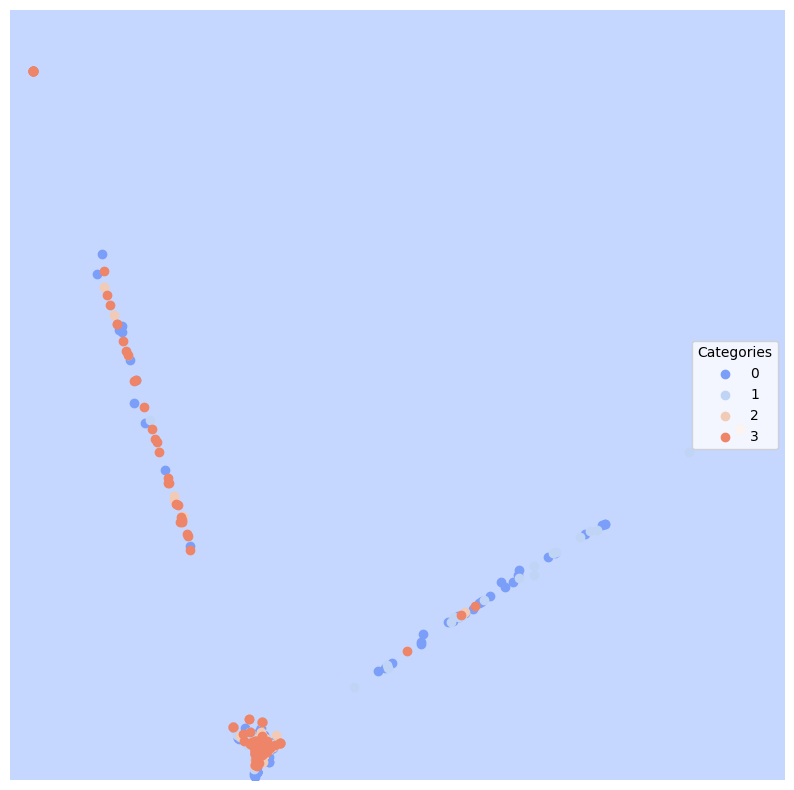

In [135]:
lucem_illud.plotregions(clf_tree, df= train_data_df)

In [137]:
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.632468,0.506085,0.362565,0.362565,1.000000
1,0.345455,0.504348,1.000000,0.354150,0.008696
2,0.188745,0.509009,1.000000,0.206763,0.018018
3,0.098268,0.506522,1.000000,0.111312,0.013043


- looks like almost everything is predicted as category 1?? The outcome suggest the model has no difference from guessing, as AUC = .5

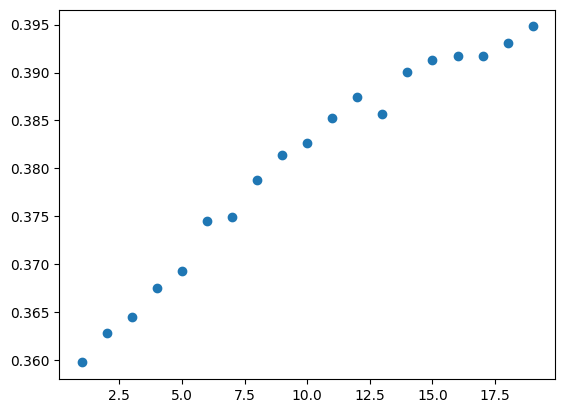

In [136]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

- The score increase (slightly) with depth, but overall they are still bad (only 40% are predicted correctly, consider the baseline of guessing 1 out of 4 characters, not to say the number of dialogues are not equally distrubuted)

Let's try a bagging (forest)

In [138]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [139]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


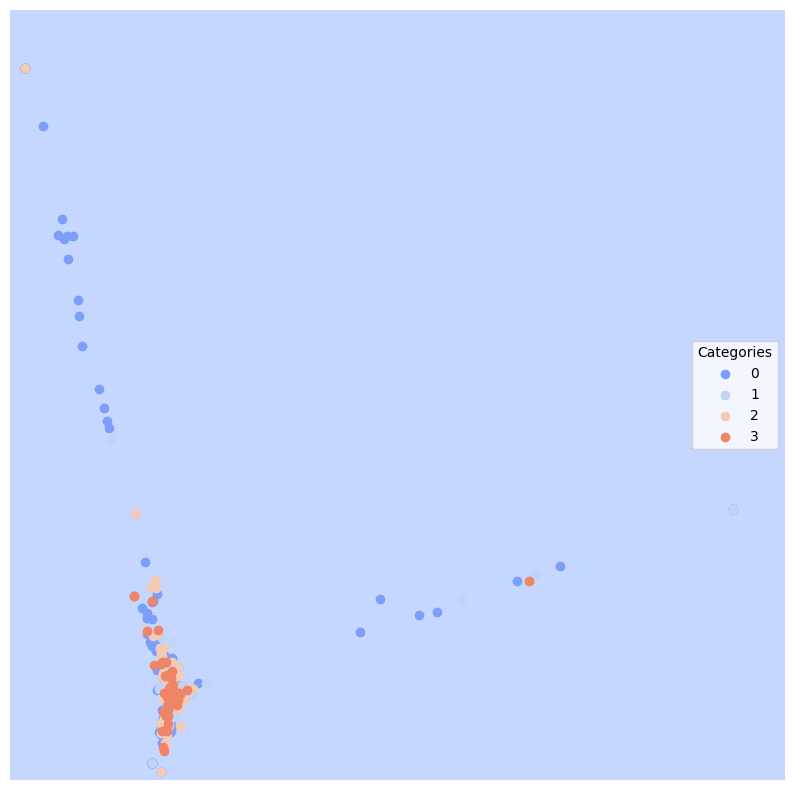

In [141]:
lucem_illud.plotregions(bag, df= test_data_df)

In [140]:
lucem_illud.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.602165,0.527905,0.373188,0.373075,0.991576
1,0.327273,0.533613,0.845070,0.385497,0.074534
2,0.184848,0.519144,1.000000,0.223137,0.038288
3,0.097835,0.518363,0.642857,0.120826,0.039130


- The performance with tree classifier is not good, but still better than a single tree
- the problem is still that almost all region are classified as 1
- The reason is two-fold: 1. Character 1 has more dialogues compare to other characters in the df; 2. all character's vects are not easily distinguishable (compare to the blob data in the example)


In the following sections I'll try to filter out similar dialogue amount for each character

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.graphics,0.718931,0.501938,0.265588,0.265565,0.971491
talk.religion.misc,0.189315,0.513216,0.326087,0.187091,0.048387
soc.religion.christian,0.274100,0.501057,1.000000,0.276214,0.002114
sci.space,0.282230,0.500053,0.285714,0.280509,0.004141


And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.29466357308584684


Let's produce another confusion matrix:

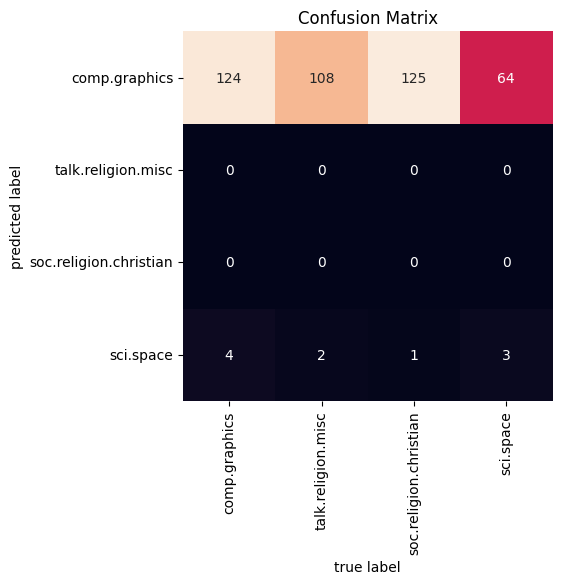

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [11]:
arknights_plot_df_filtered.shape

(11549, 6)

In [145]:
# see how many rows each unique character has

arknights_plot_df_filtered.groupby('Character').size()


Character
Amiya       4243
Ch'en       2354
Kal'tsit    3776
W           1176
dtype: int64

In [ ]:
# prompt: # Let's filter 1000 different lines randomly for each chracter

filtered_arknights_plot_df = arknights_plot_df_filtered.groupby('Character').apply(lambda x: x.sample(n=1000))
filtered_arknights_plot_df.groupby('Character').size()


In [148]:
# Let's filter 1000 different lines randomly for each chracter
sampled_arknights_plot_df = arknights_plot_df_filtered.groupby('Character').apply(lambda x: x.sample(n=1000))
sampled_arknights_plot_df.reset_index(drop=True, inplace=True)
sampled_arknights_plot_df.groupby('Character').size()


Character
Amiya       1000
Ch'en       1000
Kal'tsit    1000
W           1000
dtype: int64

In [150]:
# create train test split, it need to be stratified such that 800 line for each character is into training

holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(sampled_arknights_plot_df, test_size=holdBackFraction, stratify=sampled_arknights_plot_df['Character'])
train_data_df.groupby('category').size()


category
0    800
1    800
2    800
3    800
dtype: int64

In [151]:
# initialize k-nearest neighbor classifier

clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors=15, weights="uniform")
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])


KNeighborsClassifier(n_neighbors=15)

In [152]:
lucem_illud.evaluateClassifier(clf_knearest, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.306562,0.532292,0.324952,0.265740,0.21000
1,0.257500,0.497083,0.147059,0.249357,0.00625
2,0.254375,0.499583,0.230769,0.249856,0.00750
3,0.634062,0.534375,0.265726,0.263702,0.87125


In [153]:
# look at test data

#Add to df
test_data_df['nb_predict'] = clf_knearest.predict(np.stack(test_data_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))


Testing score:
0.25875


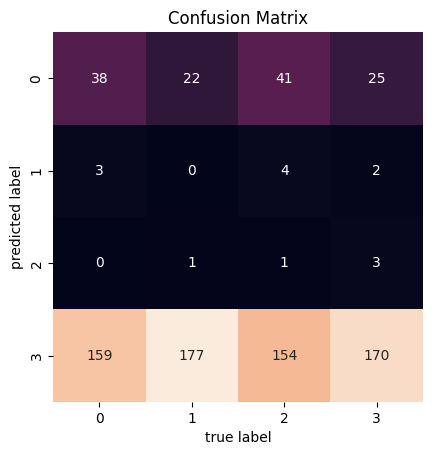

In [154]:
lucem_illud.plotConfusionMatrix(clf_knearest,test_data_df)

- look like k-nearest model is prone to predict most case into category 3 this time when we stratified sampled equal amount of dialogue from the for characters.

- The score and AUC suggest that performance is very undesirable, almost equals guessing. (the baseline for this is .25 since we have 4 categories, it got .258)


I try it with the original df without extra sub-sampling, but the kernel crashed in the process several times

- This is similar to the situation I encounter with week 3 clustering HW -- the visualization of TF-idf is in the similar shape (see above exercises), most dialogues clumped in the corner due to the informal nature of talking and lucem_illud cannot clean it to retain different talking habit of each characters? The clustering didn't perform well.





In [13]:
# use original filtered df again
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(arknights_plot_df_filtered, test_size=holdBackFraction)
train_data_df.groupby('category').size() # not equal now

category
0    3434
1    2995
2    1872
3     938
dtype: int64

In [14]:
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors=15, weights="uniform")
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_data_df)
 # this crash the kernal? seems the data size matter (this is much larger than sampled df)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('/content/uchicago-pyanno/data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.009375,0.989643,0.975610,0.966690,0.987654
Weeaboo Tales: stories about the extreme fans of japanese culture,0.012500,0.976471,1.000000,0.965441,0.952941
Bad Roommates: Tales of Irritation,0.015625,0.980695,0.961039,0.941998,0.973684
Tales From Tech Support,0.006250,0.995868,0.975000,0.975000,1.000000


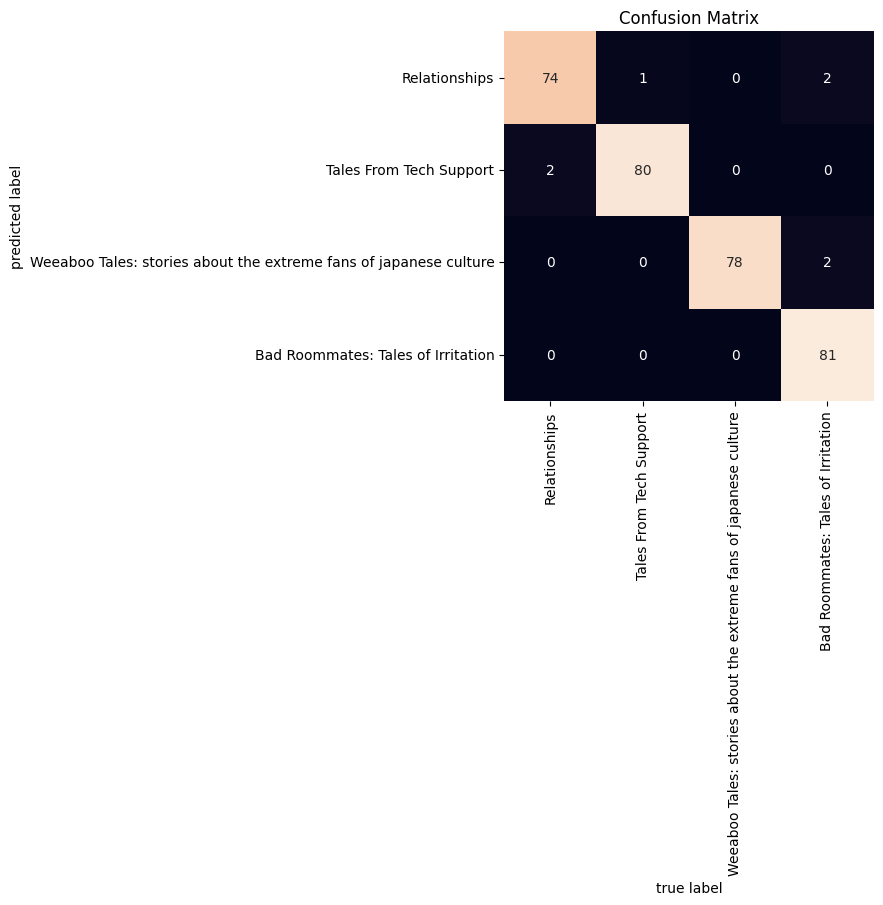

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


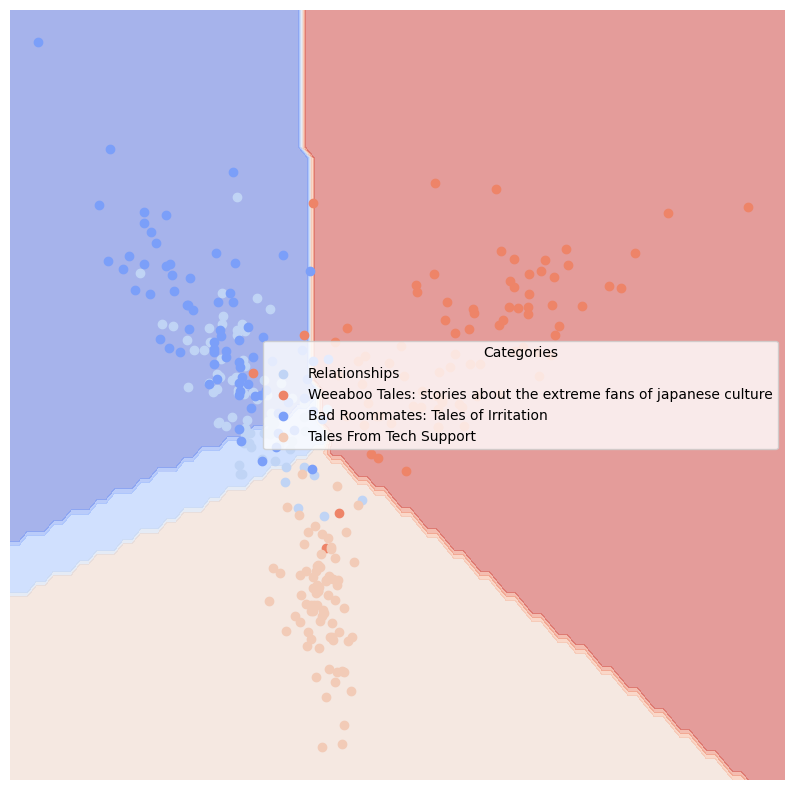

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.02500,0.962860,0.962025,0.918266,0.938272
Weeaboo Tales: stories about the extreme fans of japanese culture,0.01875,0.972215,0.975904,0.942479,0.952941
Bad Roommates: Tales of Irritation,0.01875,0.983175,0.937500,0.928289,0.986842
Tales From Tech Support,0.00000,1.000000,1.000000,1.000000,1.000000


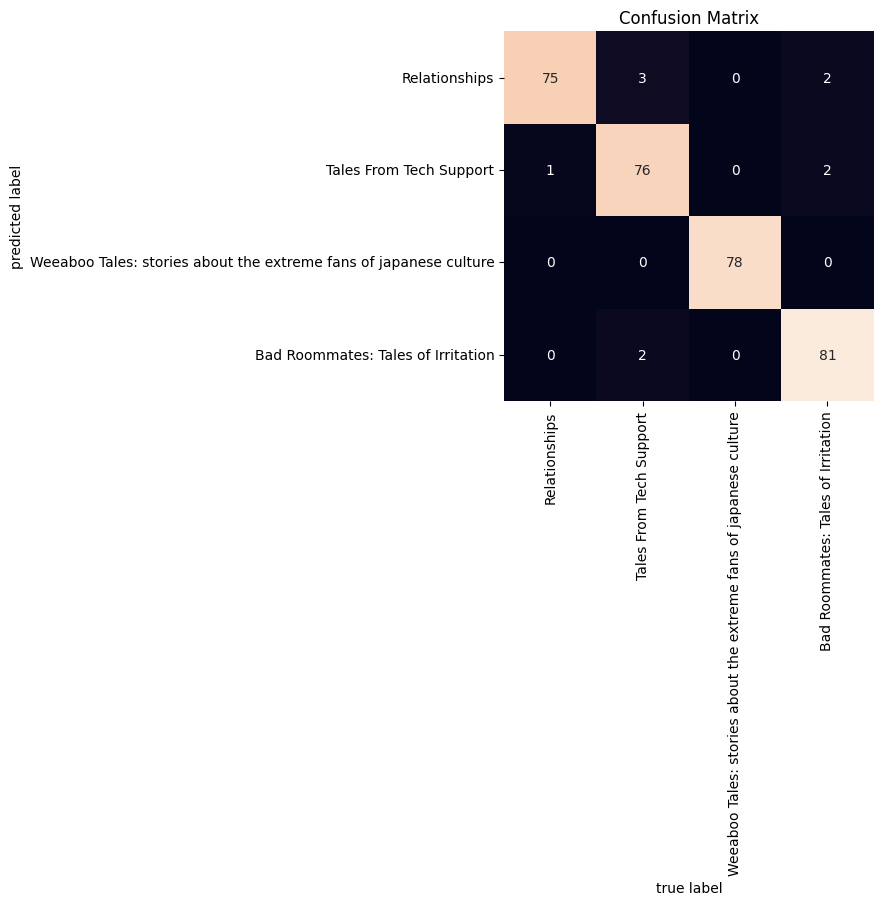

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


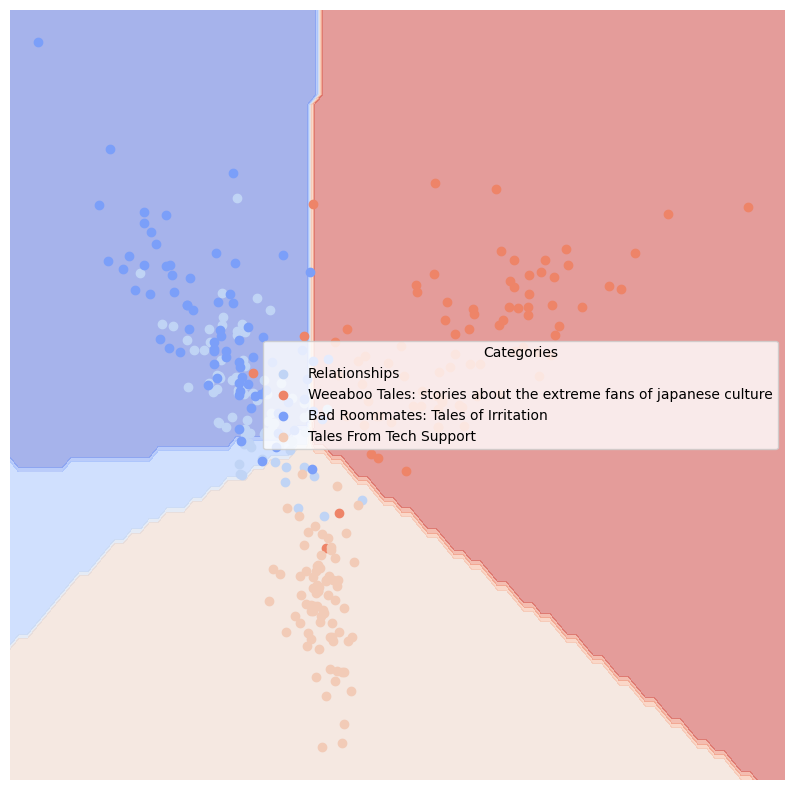

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

- We can call a neural_network classifier straightforwardly...

In [10]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(arknights_plot_df_filtered, test_size=holdBackFraction)
train_data_df.groupby('category').size()


category
0    3375
1    3028
2    1893
3     943
dtype: int64

In [11]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])
lucem_illud.evaluateClassifier(clf_nn, train_data_df)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.134971,0.888203,0.739209,0.729570,0.974222
1,0.066024,0.906128,0.968605,0.856644,0.825297
2,0.068297,0.851371,0.936376,0.728098,0.715267
3,0.024894,0.890268,0.966013,0.779115,0.783669


- This is actually incredibly better score compare to all other models above -- with AUC around .90 and around 10% error rate for each category


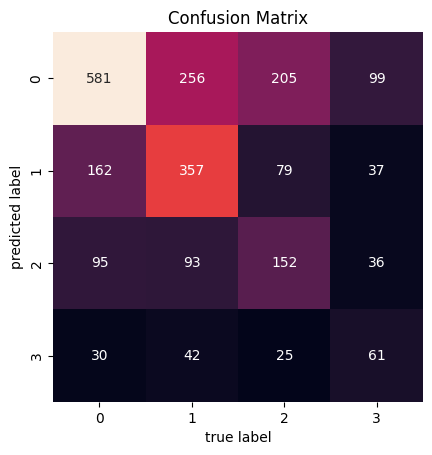

In [12]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

- The color here is not informative since each label have different count. Still we can see the precision and recall in a direct sense.
- in every category, the diag has significant more count than others, i.e. correct predictions

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6329, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5102, start: 147, end: 160


Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [14]:
from transformers import pipeline

- Let's first apply a sentiment pipeline to all the dialogues we have

In [15]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [16]:
def get_sentiment(text):
    return sentiment_pipeline(text)[0]

In [18]:
arknights_plot_df_filtered['sentiment'] = arknights_plot_df_filtered['Dialogue'].apply(get_sentiment)

<ipython-input-18-15b4eba35289>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['sentiment'] = arknights_plot_df_filtered['Dialogue'].apply(get_sentiment)


In [19]:
arknights_plot_df_filtered[['Dialogue', 'sentiment']]


,Dialogue,sentiment
Story,,
main_0_Evil Time Part 1.xlsx,Ah... S-sorry.,"{'label': 'NEGATIVE', 'score': 0.9997747540473..."
main_0_Evil Time Part 1.xlsx,...I'm already mentally prepared for that. ...,"{'label': 'POSITIVE', 'score': 0.6861746311187..."
main_0_Evil Time Part 1.xlsx,All right... I appreciate it.,"{'label': 'POSITIVE', 'score': 0.9998539686203..."
main_0_Evil Time Part 1.xlsx,About the Doctor...,"{'label': 'POSITIVE', 'score': 0.9957579970359..."
main_0_Evil Time Part 1.xlsx,Thank you... Thank you very much!,"{'label': 'POSITIVE', 'score': 0.9998596906661..."
main_0_Evil Time Part 1.xlsx,...!,"{'label': 'POSITIVE', 'score': 0.9993295669555..."
main_0_Evil Time Part 1.xlsx,Doctor...?,"{'label': 'NEGATIVE', 'score': 0.8805909752845..."
main_0_Evil Time Part 1.xlsx,I'm so happy... Doctor...,"{'label': 'POSITIVE', 'score': 0.9998792409896..."
main_0_Evil Time Part 1.xlsx,Doctor...?,"{'label': 'NEGATIVE', 'score': 0.8805909752845..."


In [27]:
# unpack the sentiment column
arknights_plot_df_filtered['Sentiment Label']= arknights_plot_df_filtered['sentiment'].apply(lambda x: x['label'])
arknights_plot_df_filtered['Sentiment Score'] = arknights_plot_df_filtered['sentiment'].apply(lambda x: x['score'])

<ipython-input-27-76bf9346796c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['Sentiment Label']= arknights_plot_df_filtered['sentiment'].apply(lambda x: x['label'])
<ipython-input-27-76bf9346796c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['Sentiment Score'] = arknights_plot_df_filtered['sentiment'].apply(lambda x: x['score'])


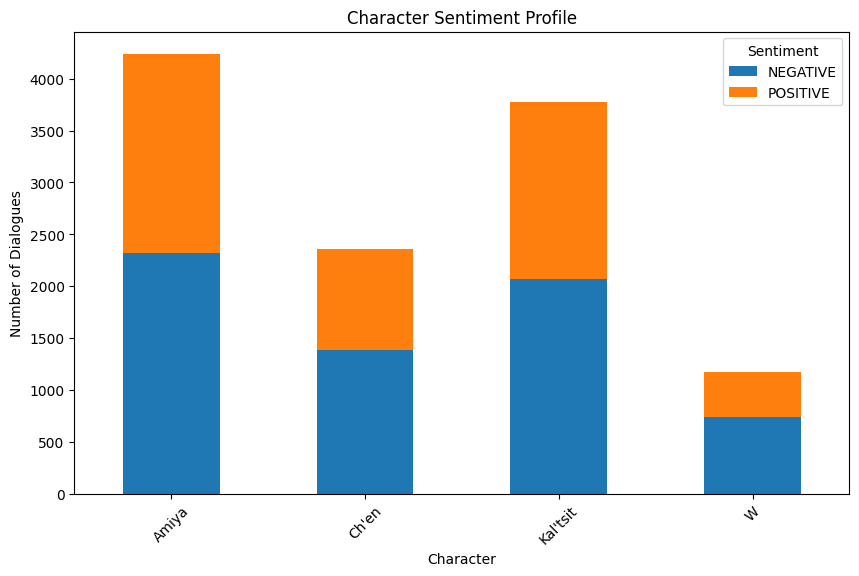

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of each sentiment type for each character
sentiment_counts = arknights_plot_df_filtered.groupby(['Character', 'Sentiment Label']).size().unstack(fill_value=0)

# Plot
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Character Sentiment Profile')
plt.xlabel('Character')
plt.ylabel('Number of Dialogues')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

We can see the distribution of sentiment across different characters:
- generally, (considering the theme of this series is on war and disease) the majority of dialogues are on the NEGATIVE side
- W and Ch'en have higher portion of NEGATIVE presentation: this make sense as they are military-related (mercenary) characters

In the project, I can work on comparing the sentiment between characters and episodes

#### llcum_illud package is not capable at handling tokenize and normalize on informal talks. Let's compare it with BERT.

In [33]:
from transformers import AutoTokenizer
tokenizer_1 = AutoTokenizer.from_pretrained("bert-base-uncased")
#model = AutoModelForQuestionAnswering.from_pretrained("bert-base-uncased")

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [34]:
tokenizer_2 = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [30]:
sub_df = arknights_plot_df_filtered.iloc[:100] # test on smaller size df

In [31]:
def tokenize_dialogue(dialogue, tokenizer):
    return tokenizer.encode_plus(dialogue, return_tensors='pt', truncation=True, max_length=512)

In [39]:
arknights_plot_df_filtered['Token_1'] = arknights_plot_df_filtered['Dialogue'].apply(tokenize_dialogue, tokenizer=tokenizer_1)
arknights_plot_df_filtered['Token_2'] = arknights_plot_df_filtered['Dialogue'].apply(tokenize_dialogue, tokenizer=tokenizer_2)

<ipython-input-39-62b465b54899>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['Token_1'] = arknights_plot_df_filtered['Dialogue'].apply(tokenize_dialogue, tokenizer=tokenizer_1)
<ipython-input-39-62b465b54899>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['Token_2'] = arknights_plot_df_filtered['Dialogue'].apply(tokenize_dialogue, tokenizer=tokenizer_2)


In [37]:
sub_df.columns

Index(['Character', 'Dialogue', 'tokenized_sents', 'normalized_sents',
       'category', 'vect', 'sentiment', 'Sentiment Label', 'Sentiment Score',
       'Token_1', 'Token_2'],
      dtype='object')

#### The Token here have a different data structure, cannot be evaluated by visualization..?
{
    'input_ids': [101, 7592, 1010, 2129, 2024, 2017, 1029, 102],
    'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0],
    'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]
}


Try compare similarity between character using embedding?

In [43]:
from transformers import AutoModel
import torch
import numpy as np

# Load the pre-trained BERT model
model_1 = AutoModel.from_pretrained('bert-base-uncased')

# Function to convert tokens to embeddings
def tokens_to_embeddings(tokens,model):
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**tokens)
        # Take the mean of the last hidden state to get a single vector representation
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

# Convert tokens to embeddings for each dialogue
arknights_plot_df_filtered['Embeddings'] = arknights_plot_df_filtered['Token_1'].apply(lambda x: tokens_to_embeddings(x,model_1))

# Aggregate embeddings by character to get a representative vector for each character
character_embeddings = arknights_plot_df_filtered.groupby('Character')['Embeddings'].apply(lambda x: torch.mean(torch.stack(x.tolist()), dim=0))





<ipython-input-43-2bb0de8475c6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arknights_plot_df_filtered['Embeddings'] = arknights_plot_df_filtered['Token_1'].apply(lambda x: tokens_to_embeddings(x,model_1))


In [45]:
# Compute similarity scores between characters
def cosine_similarity(a, b):
    a = np.squeeze(a)
    b = np.squeeze(b)

    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [46]:
similarity_score = cosine_similarity(character_embeddings['Amiya'].numpy(), character_embeddings['W'].numpy())
similarity_score

0.9711909

In [47]:
# Compute similarity scores between all pairs of characters - by AI
character_embeddings = arknights_plot_df_filtered.groupby('Character')['Embeddings'].apply(lambda x: torch.mean(torch.stack(x.tolist()), dim=0))
similarity_matrix = np.zeros((len(character_embeddings), len(character_embeddings)))

for i, character_1 in enumerate(character_embeddings):
    for j, character_2 in enumerate(character_embeddings):
        similarity_matrix[i, j] = cosine_similarity(character_1.numpy(), character_2.numpy())

# Print the similarity matrix
print(similarity_matrix)


[[1.         0.99056613 0.97562927 0.97119093]
 [0.99056613 1.         0.98322994 0.9867844 ]
 [0.97562927 0.98322994 1.         0.97140694]
 [0.97119093 0.9867844  0.97140694 1.        ]]


Looks like All characters are highly similar using the embedding created by BERT
- The 0.97 between 'Amiya' (a protagonist) and 'W' (an antagnoist) is acutally the smallest similarity..?

- also, probably with different number of dialogues, I might want to normalize and weighting the embedding before comparing like this?


